<a href="https://colab.research.google.com/github/pravallikai/Evolution-of-musical-trends-using-py/blob/main/notebooks/11_Popularity_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving spotify_pca_clusters.csv to spotify_pca_clusters.csv


In [ ]:
# This script performs popularity prediction on Spotify audio features.
import pandas as pd # Import pandas for data manipulation and analysis.
import numpy as np # Import numpy for numerical operations.
from sklearn.model_selection import train_test_split, GridSearchCV # Import train_test_split for splitting data and GridSearchCV for hyperparameter tuning.
from sklearn.preprocessing import StandardScaler # Import StandardScaler for feature scaling.
from sklearn.linear_model import LogisticRegression # Import LogisticRegression for a baseline classification model.
from sklearn.ensemble import RandomForestClassifier # Import RandomForestClassifier for an ensemble classification model.
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score, # Import various metrics for model evaluation.
                             confusion_matrix, classification_report) # Continue importing metrics.
import joblib # Import joblib for saving and loading models and scalers.
import os # Import os for operating system functionalities.
import matplotlib.pyplot as plt # Import matplotlib for plotting.
import seaborn as sns # Import seaborn for enhanced data visualizations.

# Load data (use dataset saved earlier that includes features, cluster, PCA)
df = pd.read_csv("/content/spotify_pca_clusters.csv")  # Load the preprocessed Spotify dataset into a pandas DataFrame.

# Define target: popularity (assumes 'popularity' column exists 0-100)
# Option A: binary at median
df = df.dropna(subset=['popularity']) # Remove rows where 'popularity' is missing.
median_pop = df['popularity'].median() # Calculate the median popularity to create a binary target.
df['popular'] = (df['popularity'] >= median_pop).astype(int) # Create a binary 'popular' column (1 if >= median, 0 otherwise).

# Features
features = ['energy','danceability','tempo','valence','acousticness','instrumentalness','loudness','PCA1','PCA2'] # Define the list of features to be used for training.
features = [f for f in features if f in df.columns] # Filter the features list to ensure all features exist in the DataFrame.

X = df[features] # Select the feature columns for the independent variables (X).
y = df['popular'] # Select the 'popular' column as the dependent variable (y).

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Split the data into training and testing sets, maintaining class distribution.

# Scale
scaler = StandardScaler() # Initialize the StandardScaler.
X_train_s = scaler.fit_transform(X_train) # Fit the scaler on the training features and transform them.
X_test_s = scaler.transform(X_test) # Transform the test features using the fitted scaler.

# Logistic Regression baseline
lr = LogisticRegression(max_iter=1000) # Initialize Logistic Regression model with a maximum of 1000 iterations.
lr.fit(X_train_s, y_train) # Train the Logistic Regression model on the scaled training data.
y_pred_lr = lr.predict(X_test_s) # Make predictions on the scaled test data using the Logistic Regression model.
y_prob_lr = lr.predict_proba(X_test_s)[:,1] # Get the probability of the positive class for Logistic Regression.

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1) # Initialize Random Forest Classifier with 200 estimators and parallel processing.
rf.fit(X_train, y_train) # Train the Random Forest model on the unscaled training data.
y_pred_rf = rf.predict(X_test) # Make predictions on the unscaled test data using the Random Forest model.
y_prob_rf = rf.predict_proba(X_test)[:,1] # Get the probability of the positive class for Random Forest.

# Metrics
def print_metrics(y_true, y_pred, y_prob, name="Model"): # Define a function to print evaluation metrics.
    print(name) # Print the model name.
    print("Accuracy:", accuracy_score(y_true,y_pred)) # Print the accuracy score.
    print("Precision:", precision_score(y_true,y_pred)) # Print the precision score.
    print("Recall:", recall_score(y_true,y_pred)) # Print the recall score.
    print("ROC AUC:", roc_auc_score(y_true,y_prob)) # Print the ROC AUC score.
    print(classification_report(y_true,y_pred)) # Print the classification report (precision, recall, f1-score, support).
    print(confusion_matrix(y_true,y_pred)) # Print the confusion matrix.

print_metrics(y_test, y_pred_lr, y_prob_lr, "Logistic Regression") # Call the function to print metrics for Logistic Regression.
print_metrics(y_test, y_pred_rf, y_prob_rf, "Random Forest") # Call the function to print metrics for Random Forest.

# Feature importances (RF)
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False) # Get feature importances from Random Forest and sort them.
importances.to_csv("reports/tables/feature_importances.csv") # Save the feature importances to a CSV file.
print(importances) # Print the feature importances.

# Save best model & scaler
joblib.dump(rf, "/content/rf_popularity_model.joblib") # Save the trained Random Forest model using joblib.
joblib.dump(scaler, "/content/pop_scaler.joblib") # Save the fitted StandardScaler using joblib.


KeyError: ['popularity']

In [ ]:
df.columns


Index(['year', 'track', 'artist', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo',
       'cluster', 'PCA1', 'PCA2'],
      dtype='object')

Dataset shape: (41106, 14)
   year                  track            artist  danceability  energy  \
0  1960  Jealous Kind Of Fella     Garland Green         0.417   0.620   
1  1960          Initials B.B.  Serge Gainsbourg         0.498   0.505   
2  1960           Melody Twist       Lord Melody         0.657   0.649   
3  1960          Mi Bomba Sonó        Celia Cruz         0.590   0.545   
4  1960            Uravu Solla       P. Susheela         0.515   0.765   

   loudness  speechiness  acousticness  instrumentalness  valence    tempo  \
0    -7.727       0.0403         0.490          0.000000    0.845  185.655   
1   -12.475       0.0337         0.018          0.107000    0.797  101.801   
2   -13.392       0.0380         0.846          0.000004    0.908  115.940   
3   -12.058       0.1040         0.706          0.024600    0.967  105.592   
4    -3.515       0.1240         0.857          0.000872    0.906  114.617   

   cluster      PCA1      PCA2  
0        2  0.690785 -0.85

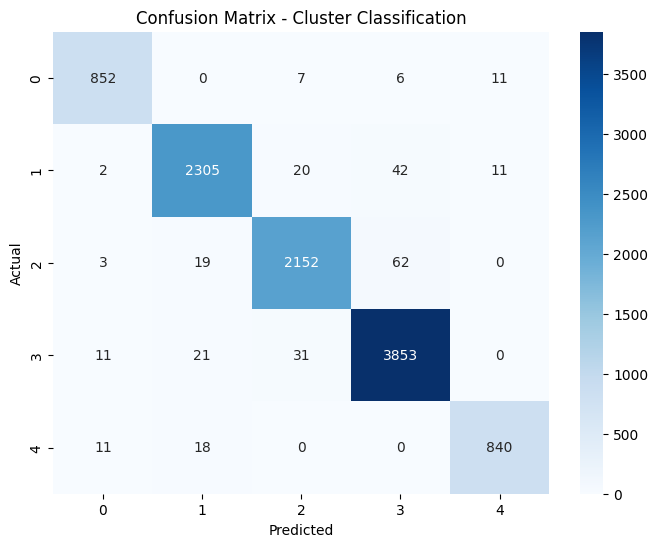

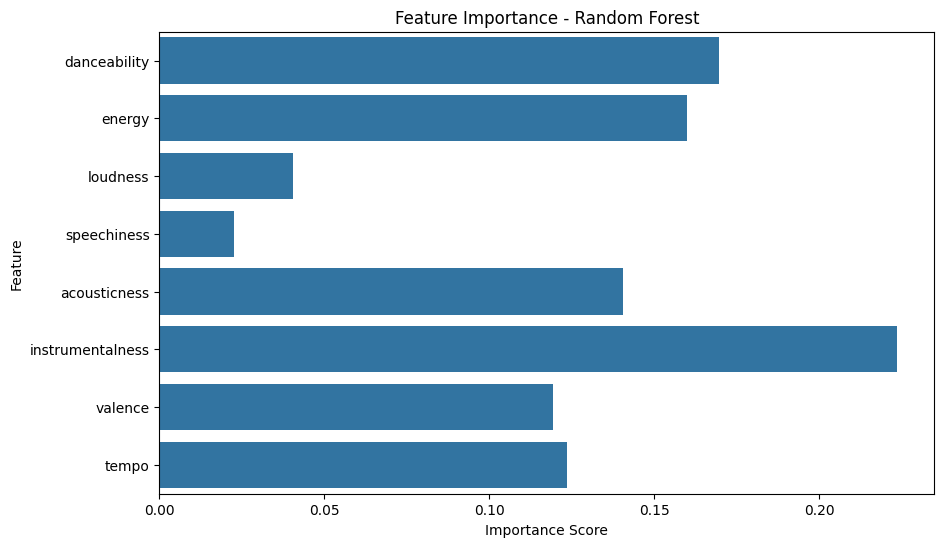

In [ ]:
# ======================================================
# NOTEBOOK 11 - Cluster Classification Model
# Predicting K-Means Clusters Using Audio Features
# ======================================================

# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load Dataset
df = pd.read_csv("/content/spotify_pca_clusters.csv")   # <-- Use your uploaded file name

print("Dataset shape:", df.shape)
print(df.head())

# 3. Check required columns
required_cols = [
    'danceability','energy','loudness','speechiness',
    'acousticness','instrumentalness','valence','tempo',
    'cluster'
]

for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"❌ ERROR: Missing column: {col}")

print("✔ All required columns exist!")

# 4. Define Features (X) and Target (y)
X = df[['danceability','energy','loudness','speechiness',
        'acousticness','instrumentalness','valence','tempo']]

y = df['cluster']   # cluster is our target

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 6. Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Model: Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_scaled, y_train)

# 8. Predictions
y_pred = rf.predict(X_test_scaled)

# 9. Evaluation
acc = accuracy_score(y_test, y_pred)
print("====================================")
print("📌 MODEL PERFORMANCE")
print("Accuracy:", acc)
print("====================================")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 10. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Cluster Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 11. Feature Importance
importances = rf.feature_importances_
feat_names = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=feat_names)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

